## Extraction performance as a function of divide-and-conquer size ##

Context: a naive implementation of the DESI spectral extraction algorithm would involve eigen-decomposition of a 2M x 2M matrix, assembled from some 16M x 16M and 16M x 2M matrices.  This is computationally intractable as-is, but we use the sparseness of the matrix to subdivide the problem into overlapping sub-extractions.  Our current default is to extract 25 spectra x 50 wavelengths + edge effect boundaries at a time.  This notebook explores potential speedups from even smaller sub-extractions.

**Stephen Bailey**<br>
Lawrence Berkeley National Lab<br>
Spring 2017

### Code to run ###

This code requires https://github.com/desihub/specter and https://github.com/sbailey/knlcode.  A minimal setup is:
```bash
git clone https://github.com/sbailey/knltest
git clone https://github.com/desihub/specter
export PYTHONPATH=`pwd`/specter/py:$PYTHONPATH
cd knltest/code
export OMP_NUM_THREADS=1
python extract-size.py
```

In [1]:
%pylab inline
import numpy as np
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


In [2]:
knl = Table.read('../doc/data/extract-size/knl.txt', format='ascii')
hsw = Table.read('../doc/data/extract-size/hsw.txt', format='ascii')

In [3]:
hsw.colnames

['nspec', 'nwave', 'ntot', 'rate']

In [4]:
knl.sort('ntot')
hsw.sort('ntot')

In [5]:
def table2rate2d(data):
    nwave_opts = sorted(set(data['nwave']))
    nspec_opts = sorted(set(data['nspec']))
    rate = np.zeros((len(nwave_opts), len(nspec_opts)))
    for row in data:
        i = nwave_opts.index(row['nwave'])
        j = nspec_opts.index(row['nspec'])
        rate[i,j] = row['rate']
    return rate

rate_knl = table2rate2d(knl)
rate_hsw = table2rate2d(hsw)

In [6]:
def plotimg(rate, xlabels, ylabels):
    imshow(rate)
    colorbar()
    xticks(range(len(xlabels)), xlabels)
    yticks(range(len(ylabels)), ylabels)
    xlabel('nspec'); ylabel('nwave')

## Extraction rate vs. extraction size ##

Current default is 25 spectra x 50 wavelengths extracted at a time.
On both KNL and Haswell, we could do better with smaller sub-extractions.

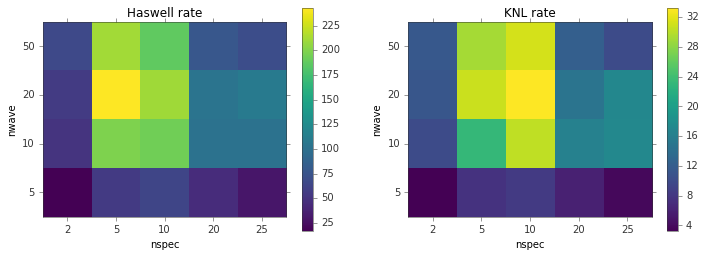

In [7]:
xlabels = sorted(set(hsw['nspec']))
ylabels = sorted(set(knl['nwave']))

set_cmap('viridis')
figure(figsize=(12,4))
subplot(121); plotimg(rate_hsw, xlabels, ylabels); title('Haswell rate')
subplot(122); plotimg(rate_knl, xlabels, ylabels); title('KNL rate')

## 3x improvement is possible ##

Going to 5-10 spectra x 20 wavelengths gains a factor of 3x speed on both KNL and Haswell.

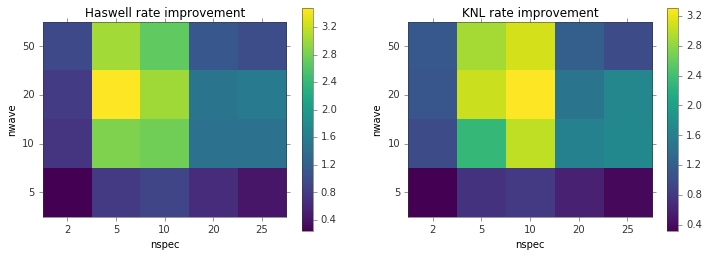

In [8]:
figure(figsize=(12,4))
subplot(121); plotimg(rate_hsw/rate_hsw[-1,-1], xlabels, ylabels); title('Haswell rate improvement')
subplot(122); plotimg(rate_knl/rate_knl[-1,-1], xlabels, ylabels); title('KNL rate improvement')

## Haswell to KNL performance ##

The best parameters for Haswell are ~7x faster than the best parameters for KNL,
and for a given extraction size (nspec,nwave), Haswell is 5x-8x faster than KNL
per process.

Haswell/KNL = 7.30920936142


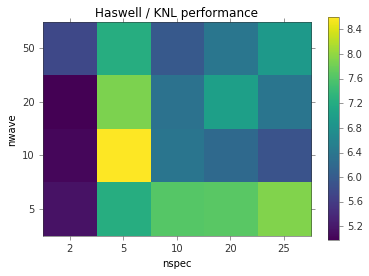

In [9]:
r = np.max(rate_hsw) / np.max(rate_knl)
print("Haswell/KNL = {}".format(r))
plotimg(rate_hsw/rate_knl, xlabels, ylabels)
title('Haswell / KNL performance')

## KNL cache problems? ##

There was a theory that L2 cache misses on KNL were hurting its performance relative
to Haswell and that going to smaller extraction sizes would help.  This doesn't appear
to be the case -- although both Haswell and KNL prefer smaller extraction sizes, Haswell
continues to significantly outperform KNL by much more than the ratio of clock speeds
(2.3/1.4).